## Building the Segmentation Masks

Before we are able to start working on training a model to cluster the images we need to remove any biasing information from the images. This involves creating something called a segmentation mask, which will essentially remove any biassing information involved in capturing the herbarium sheet samples. The way that the mask works is we will create a black and white image, where there is no presence of the plant sample we will color the image black and where there is we will color the image white. 

In terms of biasing information think, camera settings, or any identifying labels. Ideally we want the segmentation mask to still capture all the information that a paleo-botanist would use when delineating species. I'm told that most of the time this information if found almost entirely in the morphology of the leaves. 

We will be using a workflow described in the following [article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7328659/) by Alexander White, Rebecca Dikow, et.al, 
Their article describes training a neural network to be able to recreate segmentation masks for fern shaped herbarium sheets. To accomplish this tasks they had to develop a workflow for creating several 'ground truth' masks. This is the part of their research that we will be taking advantage of. Currently this workflow involves a good amount of editing by hand if in the later stages of our research, we decide that more data is needed we might spend time training a neural network to create these masks for us.

Mapping out the workflow for building the segmentation masks, consider the following
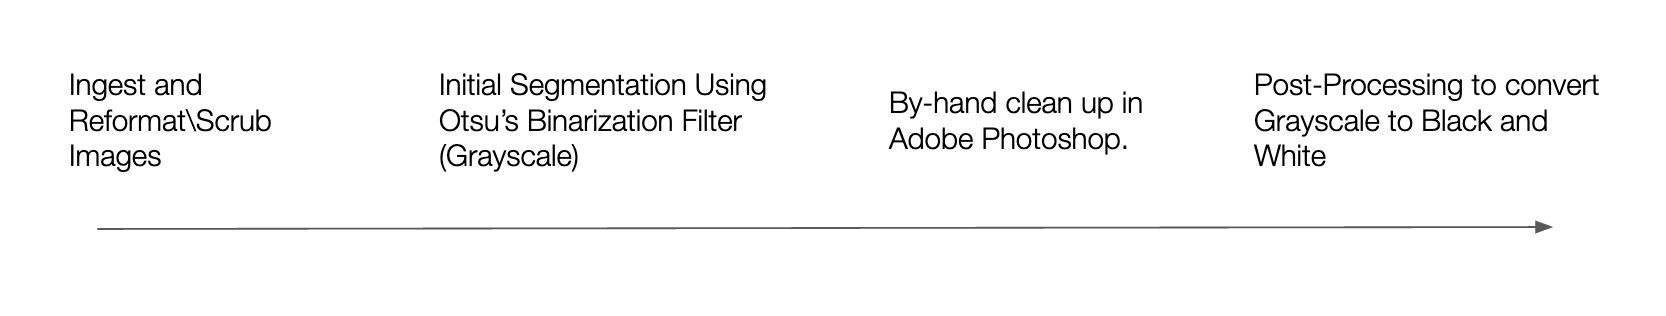

## Reformatting images
Some of the Herbarium Sheets were received and stored in the .tiff file format. In order to save space and have our data in one file format we will be converting them to .jpg. 

In [1]:
import os
from PIL import Image

## Assuming the current directory has the images. 
yourpath = os.getcwd()
## Extracting file names in current directory. 
for root, dirs, files in os.walk(yourpath, topdown=False):
   ## Looping through filenames
    for name in files:
        print(os.path.join(root, name))
        
        ## If file ends in tif, check to see if it's already converted. If not then convert it. 
        if os.path.splitext(os.path.join(root, name))[1].lower() == ".tif":
            if os.path.isfile(os.path.splitext(os.path.join(root, name))[0] + ".jpg"):
                print("A jpeg file already exists for %s" % name)
            # If a jpeg is *NOT* present, create one from the tiff.
            
            else:
                outfile = os.path.splitext(os.path.join(root, name))[0] + ".jpg"
                try:
                    im = Image.open(os.path.join(root, name))
                    print("Generating jpeg for %s" % name)
                    im.thumbnail(im.size)
                    im.save(outfile, "JPEG", quality=100)
                except e:
                    print(e)

/Users/stefanofochesatto/Documents/Documents/College Work/Homework-Spring-2022/Herbarium Lab research/.ipynb_checkpoints/Building Segmentation Mask Code-checkpoint.ipynb
/Users/stefanofochesatto/Documents/Documents/College Work/Homework-Spring-2022/Herbarium Lab research/Building Segmentation Mask Code.ipynb
/Users/stefanofochesatto/Documents/Documents/College Work/Homework-Spring-2022/Herbarium Lab research/example_foreground.jpg
/Users/stefanofochesatto/Documents/Documents/College Work/Homework-Spring-2022/Herbarium Lab research/Segmentation Workflow. .png
/Users/stefanofochesatto/Documents/Documents/College Work/Homework-Spring-2022/Herbarium Lab research/example.jpg


## Applying the Initial Segmentation

The code for the initial segmentation used in the article by Alexander White, Rebecca Dikow, et al. can be found [here](https://github.com/sidatasciencelab/fern_segmentation/blob/master/segmentation_code.ipynb). This initial code relies on an a python wrapper for OpenCV(Computer Vision) called cv2. The code simply performs Otsu's biniarization method to create an initial mask. 

#### Otsu's Binarization Method

Otsu's Method finds a threshold for making the mask, which minimized the intra-class variance(variance between the two black and white classes.) Here is an example of how it works. First we take the grayscale image then create a frequency histogram of it's pixel intensity values(1-255). We scan through this frequency histogram, everything to the left of our scan is put into one class everything to the right of our scan is put into another class. At each iteration we compute a cost function which is a weighted sum of the variances in each class, 

$$\sigma^2_w(t) = w_1(t)\sigma^2_1(t) + w_2(t)\sigma^2_2(t).$$


$$w_1(t) = \sum_{i = 1}^{t - 1}p(i)$$

$$w_2(t) = \sum_{i = t}^{255}p(i)$$

Since there are only two classes, namely black and white we know that the threshold which minimizes intra-class variance, must also maximize inter-class variance. Which is computed with the following, 

$$ \sigma^2_b(t) = w_1(t)w_2(t)\left(\mu_1(t)- \mu_2(t)\right)^2.$$


In [1]:
## importing relevant libraries
import cv2 #openCV for image processing
import copy #Standard copy library for copying openCV objects
from matplotlib import pyplot as plt #Matplotlib for display
import numpy as np
plt.rcParams['figure.figsize'] = [5,5] #resizing default figure size jupyter display window

In [2]:
import ipywidgets as widgets #ipywidgets for Otsu Binarization Demo Widget

In [3]:
## Area for Otsu Binarization Demo
orig = cv2.imread("example.jpg", cv2.IMREAD_GRAYSCALE)
### Generating the greyscale value histogram
freq = np.zeros(256)
for i in range(len(orig)):
    for j in range(len(orig[0])):
        freq[orig[i,j]] += 1

### Normalizing to get probability dist. 
total = sum(freq)
prob = freq/total

## Applying Otsu's binarization algorithm to find the threshold which maximizes inter-class variance, 
inter_variance = np.zeros(255)
for i in range(1,256):
    w_0 = sum(prob[0:i-1]) 
    w_1 = sum(prob[i:255])
    if (w_0 == 0 or w_1 == 0):
        inter_variance[i-1] = 0
    else:
        mu_0 = sum(range(1,256)[1:i-1]*prob[1:i-1])/w_0
        mu_1 = sum(range(1,256)[i:255]*prob[i:255])/w_1
        inter_variance[i-1] = w_0*w_1*(mu_0 - mu_1)**2

## Pulling threshold where inter_variance is maximized
Otsu_Thresh = np.argmax(inter_variance)
print(str('This is the Otsu threshold computed by the novel implemintation: ' + str(Otsu_Thresh)))

This is the Otsu threshold computed by the novel implemintation: 133


In [4]:
%%capture
%matplotlib inline
from ipywidgets import interact, widgets
from IPython.display import display
## Demonstrations of how the thresholding works. 

## Import demo image
image = cv2.imread("example.jpg", cv2.IMREAD_GRAYSCALE)

## Callback function for generating thresholded image.
def f(user_thresh):
    mask = copy.deepcopy(orig)
    mask = np.where(image > user_thresh, 255, 0)      
    ax_new.imshow(mask, cmap="gray")
    fig.canvas.draw()
    display(fig)
    
## Defining Demo Widget.
fig = plt.figure(figsize=(20, 10))
ax_orig = fig.add_subplot(121) 
ax_new = fig.add_subplot(122) 

ax_orig.imshow(image, cmap="gray")
ax_new.imshow(image, cmap="gray")

In [5]:
## Demo Widget Starter Code. Naive image generation is 
interact(f, user_thresh=widgets.IntSlider(min=0,max=255,step=1,value=1, continuous_update=False));

interactive(children=(IntSlider(value=1, continuous_update=False, description='user_thresh', max=255), Output(…

[[237 237 237 ... 255 255 255]
 [237 237 237 ... 255 255 255]
 [237 237 237 ... 255 255 255]
 ...
 [ 27  30  35 ...  35  35  35]
 [ 28  31  35 ...  32  32  32]
 [ 28  31  35 ...  37  37  36]]


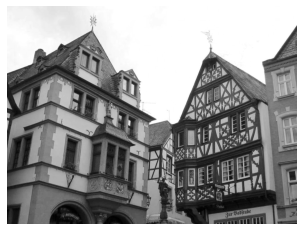

In [7]:
## Applying Otsu Binarization to the Herbarium Sheet samples
orig = cv2.imread("example.jpg", cv2.IMREAD_GRAYSCALE) #imports the image
plt.axis('off')
plt.imshow(orig, 'gray')
print(orig)

In [8]:
## Function from cv2 library applies otsu binarization to image, returns thresholded image array 'thresh'
# and threshold value 'ret'. The 'thresh' image array is only black and white, from this array we will extract 
# a foreground and backround mask.
cvcopy = copy.deepcopy(orig)
ret, thresh = cv2.threshold(cvcopy,0,255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


            
## Using the np.where() function evaluates pixels simultaneously and is significantly faster, which matters when herbarium sheets
## are significantly larger and we need threshold them in large batches. 
mask_fore = copy.deepcopy(orig)
mask_back = copy.deepcopy(orig)
mask_fore = np.where(orig > ret, 0, 255)  
mask_back = np.where(orig > ret, 255, 0)  

## Implementation in A.White, R.Dikow paper 
#for i in range(len(thresh)):
#    for j in range(len(thresh[0])):
#        if(thresh[i,j] == 0): 
#            mask_fore[i,j] = 0 
#        if(mask_fore[i,j] > 0):
#            mask_fore[i,j] = 255
#    
#    
#for i in range(len(mask_fore)):
#    for j in range(len(mask_fore[0])):
#        if(mask_fore[i,j] == 0): 
#            mask_back[i,j] = 255
#        if(mask_fore[i,j] == 255):
#            mask_back[i,j] = 0


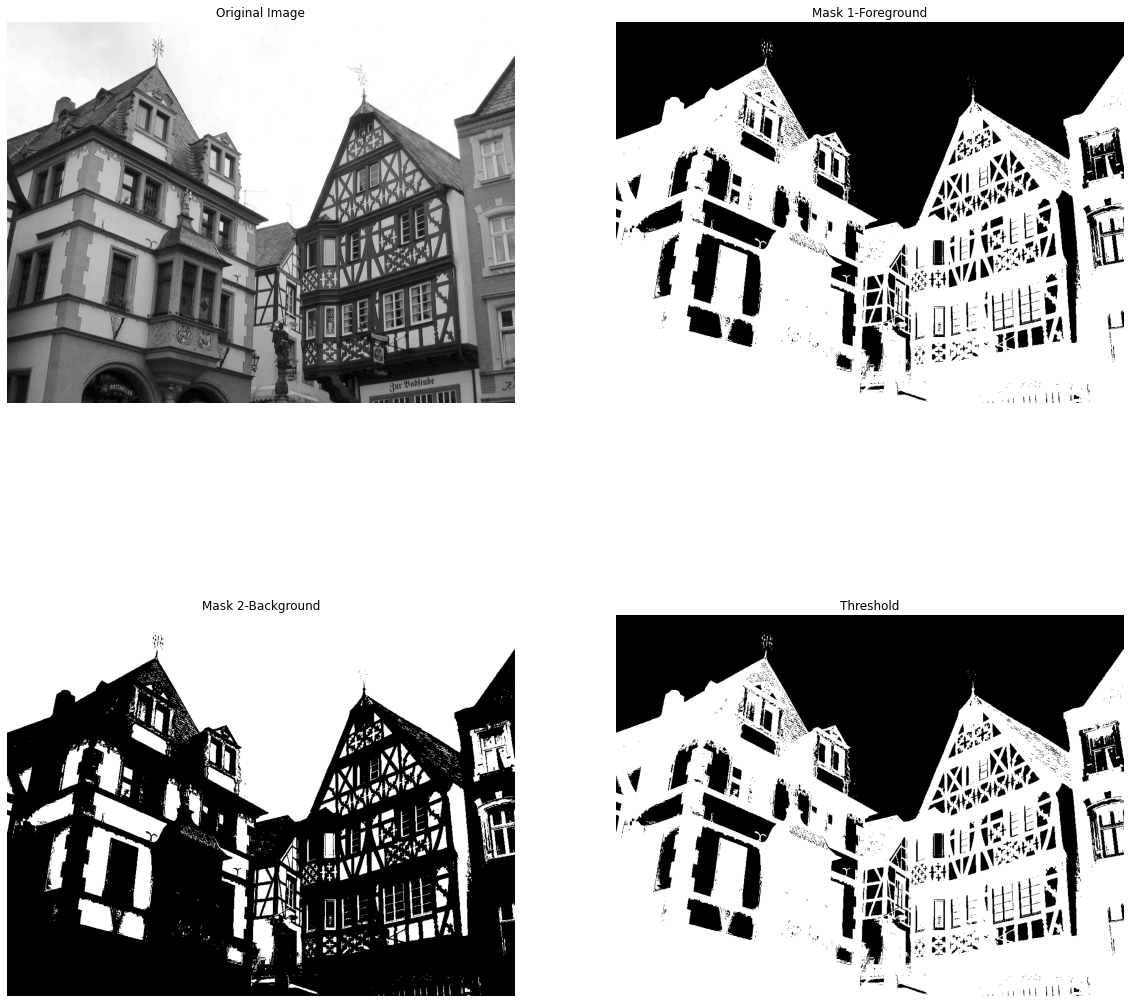

In [9]:
plt.rcParams['figure.figsize'] = [20, 20]
plt.subplot(221) #original image
plt.axis('off')
plt.title("Original Image")
plt.imshow(orig,'gray')

plt.subplot(222) #mask 1 - foreground
plt.axis('off')
plt.title("Mask 1-Foreground")
plt.imshow(mask_fore,'gray')

plt.subplot(223) #mask 2 - background
plt.axis('off')
plt.title("Mask 2-Background")
plt.imshow(mask_back,'gray')

plt.subplot(224) #mask 2 - background
plt.axis('off')
plt.title("Threshold")
plt.imshow(thresh,'gray')

plt.show()

In [11]:
#### Full Script For Initial segmentation mask 
path = '/Users/stefanofochesatto/Desktop/HerbariumSheets ' ##Supply Full Path to images directory


#### Directory Management
os.chdir(path) #Change the working directory to the image directory

Imagelist = [] #Pull the current list of files in image directory
for file in os.listdir(path):
    if file.endswith(".jpg"): # Herbarium Sheets are in jpg format
        Imagelist.append(file)



## Creating Directory for each mask. 
dir_fore = 'Foreground_Masks'
os.mkdir(os.path.join(path, dir_fore))
dir_back = 'Background_Masks'
os.mkdir(os.path.join(path, dir_back))


for i in Imagelist:
    os.chdir(path) # We have to set the path everytime since cv2 can't handle relative paths without it.
    currentImage = cv2.imread(i, cv2.IMREAD_GRAYSCALE) # Reading in the current image
    
    # Applying the threshold
    threshImage = copy.deepcopy(currentImage)
    ret, thresh = cv2.threshold(threshImage,0,255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Creating the Masks
    mask_fore = copy.deepcopy(currentImage)
    mask_fore = np.where((currentImage).astype(np.uint8) > ret, 0, 255)  
    image_fore = Image.fromarray((mask_fore).astype(np.uint8))
    os.chdir(str(path+'/Foreground_Masks'))
    image_fore.save(str(i),"JPEG") 
    
    
    mask_back = copy.deepcopy(currentImage)
    mask_back = np.where((currentImage).astype(np.uint8) > ret, 255, 0) 
    image_back = Image.fromarray((mask_back).astype(np.uint8))
    os.chdir(str(path+'/Background_Masks'))
    image_back.save(str(i),"JPEG")     

Premature end of JPEG file


'/'